In [1]:
import matplotlib.pyplot as plt
from LIMxCMBL.toy import *

/sdf/group/kipac/users/delon/miniconda3/lib/python3.12/site-packages/pyccl/pk2d.py:285: RuntimeWarning: divide by zero encountered in log
  lk_use = np.log(k_use)
100%|██████████| 50/50 [00:00<00:00, 178.21it/s]


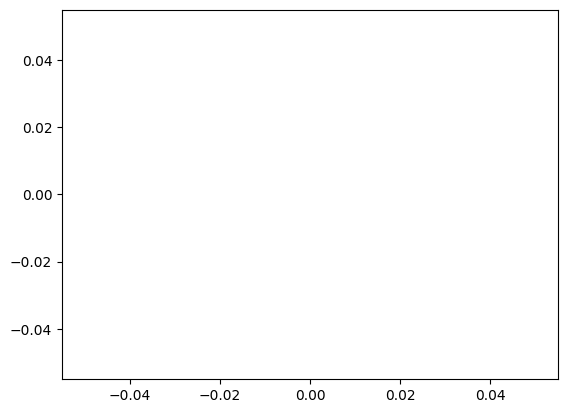

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 10,
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1,
    'figure.figsize': (6, 6/1.618),
    'figure.constrained_layout.use': True,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

# analyze Monte Carlo results

## load all the sims

In [3]:
import os

pkl_files = []
for file in os.listdir('/sdf/scratch/kipac/delon/toy_model_LIMxCMBL'):
    if file.endswith('.pkl'):
        pkl_files.append(file)

pkl_files = sorted(pkl_files)

In [4]:
n_runs = 0
measured_spectra = {}

process = {
        'kk':     [1],
        'LC_Ik' : [(n_k_bins)],
        'nLC_Ik': [(n_k_bins)],
        'LC_II':  [((n_k_bins), (n_k_bins)), ],
        'nLC_II': [((n_k_bins), (n_k_bins)), ]
}

for _type in process:
    measured_spectra[_type] = np.zeros(process[_type][-1], dtype=np.complex128)
    measured_spectra[_type+'_MSE'] = np.zeros(process[_type][-1])

In [5]:
for pkl_file in tqdm(pkl_files):
    _n_runs = int(pkl_file.split('_')[-1].split('.')[0])
    oup_mc_fname = '/sdf/scratch/kipac/delon/toy_model_LIMxCMBL/monte_carlo_toy_model_nrun_%d.pkl'%(_n_runs)
    with open(oup_mc_fname, 'rb') as f:
        _measured_spectra = pickle.load(f)
        
    for _type in measured_spectra:
        measured_spectra[_type] += _measured_spectra[_type]
    n_runs += _n_runs
    print('tot nrun', n_runs)

for _type in process:
    measured_spectra['estimated_'+_type] = measured_spectra[_type]/n_runs
    measured_spectra['estimated_'+_type+'_MSE'] = measured_spectra[_type+'_MSE']/n_runs/(n_runs - 1)

 22%|██▏       | 37/171 [00:00<00:00, 159.40it/s]

tot nrun 1000
tot nrun 1561031
tot nrun 3121063
tot nrun 4681096
tot nrun 6241130
tot nrun 7801165
tot nrun 9361201
tot nrun 10921238
tot nrun 12481276
tot nrun 14041315
tot nrun 15601355
tot nrun 17161396
tot nrun 18721438
tot nrun 20281481
tot nrun 21841525
tot nrun 23401570
tot nrun 24961616
tot nrun 26521663
tot nrun 28081711
tot nrun 29641760
tot nrun 31201810
tot nrun 32761861
tot nrun 34321913
tot nrun 35881966
tot nrun 37442020
tot nrun 39002075
tot nrun 40562131
tot nrun 42122188
tot nrun 43682246
tot nrun 45242305
tot nrun 46802365
tot nrun 48362426
tot nrun 49922488
tot nrun 51482551
tot nrun 53042615
tot nrun 54602686
tot nrun 56162758
tot nrun 57722831
tot nrun 59282905
tot nrun 60842980
tot nrun 62403056
tot nrun 63963133
tot nrun 65523211
tot nrun 67083290
tot nrun 68643370
tot nrun 70203451
tot nrun 71763533
tot nrun 73323619
tot nrun 74883706
tot nrun 76443794
tot nrun 78003883
tot nrun 79563973
tot nrun 81124064
tot nrun 82684156
tot nrun 84244249
tot nrun 85804343
to

 87%|████████▋ | 149/171 [00:00<00:00, 316.00it/s]

tot nrun 113886808
tot nrun 115446967
tot nrun 117007127
tot nrun 118567294
tot nrun 120127462
tot nrun 121687635
tot nrun 123247809
tot nrun 124807984
tot nrun 126368160
tot nrun 127928337
tot nrun 129488515
tot nrun 131048694
tot nrun 132608874
tot nrun 134169055
tot nrun 135729237
tot nrun 137289420
tot nrun 137289422
tot nrun 137292308
tot nrun 137295195
tot nrun 137298083
tot nrun 137300972
tot nrun 137303862
tot nrun 137306753
tot nrun 137309645
tot nrun 137312538
tot nrun 137315439
tot nrun 137318341
tot nrun 137321244
tot nrun 137324148
tot nrun 137327053
tot nrun 137329959
tot nrun 137332866
tot nrun 137335774
tot nrun 137338683
tot nrun 137341593
tot nrun 137344504
tot nrun 137347416
tot nrun 137350329
tot nrun 137353243
tot nrun 137356158
tot nrun 137359074
tot nrun 137361991
tot nrun 137364909
tot nrun 137367828
tot nrun 137370748
tot nrun 137373669
tot nrun 137376591
tot nrun 137379514
tot nrun 137382438
tot nrun 137385363
tot nrun 137388289
tot nrun 137391216
tot nrun 137

100%|██████████| 171/171 [00:00<00:00, 264.43it/s]


tot nrun 137464716
tot nrun 137467669
tot nrun 137470623
tot nrun 137473578
tot nrun 137476534
tot nrun 137479491
tot nrun 137482449
tot nrun 137485408
tot nrun 137488368
tot nrun 137491329
tot nrun 137494291
tot nrun 137497256
tot nrun 137497768
tot nrun 137549002
tot nrun 145109004
tot nrun 152669007
tot nrun 160229011
tot nrun 167789016
tot nrun 175349022
tot nrun 182909029
tot nrun 190469037
tot nrun 198029046


## projected quantities

In [6]:
estimated_kk = measured_spectra['estimated_kk']
estimated_kk_MSE = measured_spectra['estimated_kk_MSE']
print((measured_spectra['estimated_kk'] - expected_kappa2)/expected_kappa2)
print(jnp.sqrt(measured_spectra['estimated_kk_MSE'])/measured_spectra['estimated_kk'])

[7.90896029e-05+0.j]
[0.00010048+0.j]


## LIM Lensing cross 3D x 2D

In [7]:
for _type in ['LC', 'nLC']:
    _estimated_II = measured_spectra['estimated_'+_type+'_II']
    _estimated_Ik = measured_spectra['estimated_'+_type+'_Ik']
    _estimated_cov = estimated_kk * _estimated_II + _estimated_Ik.reshape(-1, 1) * jnp.conj(_estimated_Ik.reshape(1, -1))
    measured_spectra['estimated_'+_type+'_cov'] = _estimated_cov

Text(0, 0.5, '$|\\langle I(k)\\kappa\\rangle|$')

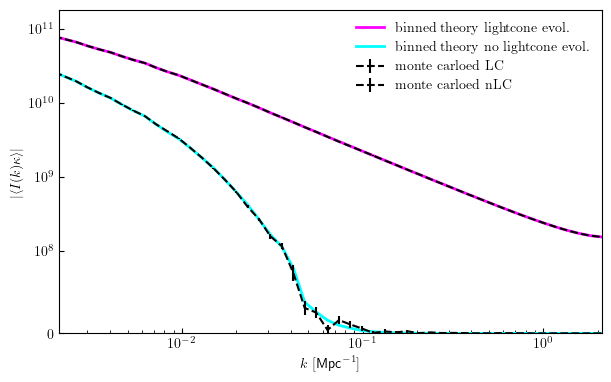

In [8]:
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa), label='binned theory lightcone evol.', c='magenta', lw=2)
plt.plot(k_bin_centers, jnp.abs(binned_Ik_kappa_noLC), label='binned theory no lightcone evol.', c='cyan', lw=2)


color = {'LC': 'k', 'nLC':'k'}
for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra['estimated_'+_type+'_Ik'])
    binned_rmse = jnp.sqrt(measured_spectra['estimated_'+_type+'_Ik_MSE'])
    plt.errorbar(k_bin_centers, curr_spectra, yerr=jnp.real(binned_rmse),
                 label='monte carloed %s'%_type, ls='--', c=color[_type])

plt.legend(frameon=False)

plt.yscale('symlog', linthresh=1e8)
plt.ylim(0, None)

# plt.xscale('symlog', linthresh=1e-3)
plt.xscale('log')
plt.xlim(k_bin_centers[1], k_bin_centers[-1])

plt.xlabel(r'$k$ [${\sf Mpc}^{-1}$]')
plt.ylabel(r'$|\langle I(k)\kappa\rangle|$')

# compute monte carlo estiamtd SNR

In [9]:
SNR2s = {'LC':np.zeros(n_k_bins), 'nLC': np.zeros(n_k_bins),
         'LC_MSE':np.zeros(n_k_bins), 'nLC_MSE': np.zeros(n_k_bins),
         'theoryLC':np.zeros(n_k_bins), 'theorynLC': np.zeros(n_k_bins),}

In [10]:
theory_covs = {'LC': expected_binned_cov, 'nLC': expected_binned_cov_noLC}
theory_Ik = {'LC': binned_Ik_kappa, 'nLC': binned_Ik_kappa_noLC}

In [11]:
# @jax.jit
# def get_MSE_of_SNR2(
#     Ik,
#     II,
#     Ik_MSE,
#     II_MSE
# ):
#     # I am assuming a bunch of things that are correlated are not correlated, this is just to get a sense of the SNR2 error bar
#     # but nothing precise
#     II_flat = II.reshape(-1)
    
#     def compute_snr2_flat_II(Ik, II_flat, kk):
#         II = II_flat.reshape(len(Ik), len(Ik))
#         cov = kk * II + Ik.reshape(-1, 1) * jnp.conj(Ik.reshape(1, -1))
#         x_sol, _, _, _ = jnp.linalg.lstsq(cov, jnp.conj(Ik))
#         return jnp.real(Ik @ x_sol)

#     grad_II_flat = jax.jacrev(compute_snr2_flat_II, argnums=1)(Ik, II_flat, estimated_kk)
#     grad_II = grad_II_flat.reshape(II.shape)

#     grad_Ik = jax.jacrev(compute_snr2_flat_II, argnums=0)(Ik, II_flat, estimated_kk)
#     grad_kk = jax.jacrev(compute_snr2_flat_II, argnums=2)(Ik, II_flat, estimated_kk)

#     ret = estimated_kk_MSE * grad_kk**2  + jnp.sum((grad_Ik)*jnp.conj(grad_Ik) * Ik_MSE) + jnp.sum((grad_II)*jnp.conj(grad_II).T * II_MSE)    
#     return ret

In [12]:
for _type in ['LC', 'nLC']:
    for kill_idx in trange(n_k_bins):
        #throw out k <= k_bin_edge[kill_idx]
        x,resid,rank,s = jnp.linalg.lstsq(measured_spectra['estimated_'+_type+'_cov'][kill_idx:, kill_idx:], 
                                          jnp.conj(measured_spectra['estimated_'+_type+'_Ik'][kill_idx:]))
        
        SNR2s[_type][kill_idx] = jnp.real(measured_spectra['estimated_'+_type+'_Ik'][kill_idx:] @ x)


        # slow...
        # SNR2s[_type+'_MSE'][kill_idx] = jnp.real(get_MSE_of_SNR2(
        #     (measured_spectra['estimated_'+_type+'_Ik'])[kill_idx:],
        #     (measured_spectra['estimated_'+_type+'_II'])[kill_idx:, kill_idx:],
        #     measured_spectra['estimated_'+_type+'_Ik_MSE'][kill_idx:],
        #     measured_spectra['estimated_'+_type+'_II_MSE'][kill_idx:, kill_idx:]))[0]

        x,resid,rank,s = jnp.linalg.lstsq(theory_covs[_type][kill_idx:, kill_idx:], 
                                          jnp.conj(theory_Ik[_type][kill_idx:]))
        SNR2s['theory'+_type][kill_idx] = jnp.real(theory_Ik[_type][kill_idx:] @ x)

100%|██████████| 49/49 [00:00<00:00, 323.27it/s]


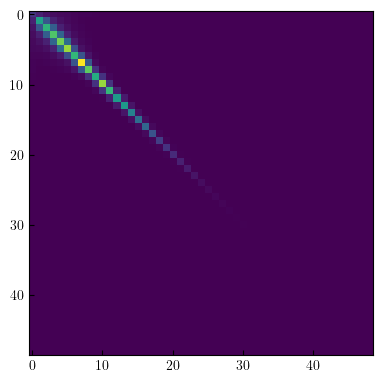

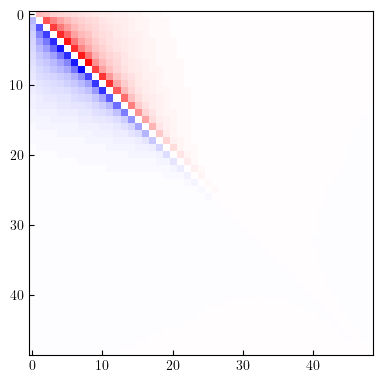

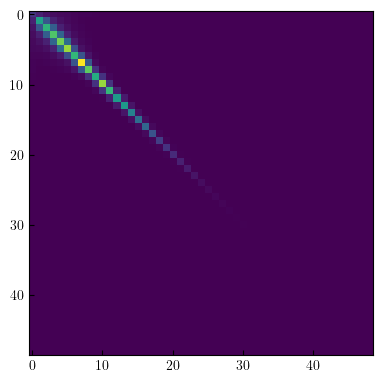

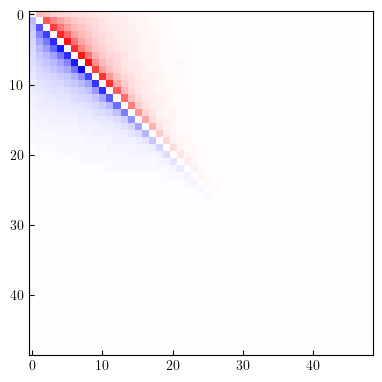

In [13]:
vb = np.max(np.abs(theory_covs['LC']))
plt.imshow(jnp.real(theory_covs['LC']), vmin = 0, vmax=vb, cmap='viridis')
plt.show()
plt.imshow(jnp.imag(theory_covs['LC']), vmin = -vb, vmax=vb, cmap='seismic')
plt.show()
plt.imshow(jnp.real(measured_spectra['estimated_LC_cov']), vmin = 0, vmax=vb, cmap='viridis')
plt.show()
plt.imshow(jnp.imag(measured_spectra['estimated_LC_cov']), vmin = -vb, vmax=vb, cmap='seismic')
plt.show()

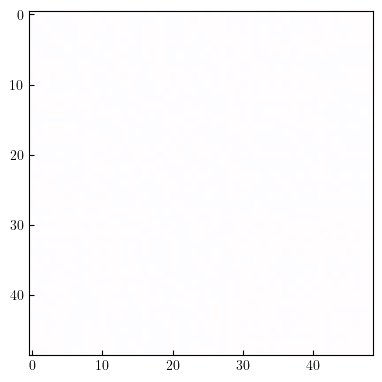

In [14]:
plt.imshow(jnp.real(theory_covs['LC'] - measured_spectra['estimated_LC_cov']), vmin = -vb/1, vmax=vb/1, cmap='seismic')
plt.show()

In [95]:
LC_k = 'magenta'
nLC_color = 'cyan'
nLC_lw = 3
color = {'LC': 'k', 'nLC':'k'}

In [128]:
#note that no LC SNR invariant wrt normalization Kbar
#also <I(noLC) kappa> ~ Kbar so can rescale however we like

In [158]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2

In [179]:
_bbox = axs[0].get_position()
plt_cntr = _bbox.xmin + (_bbox.xmax - _bbox.xmin)/2

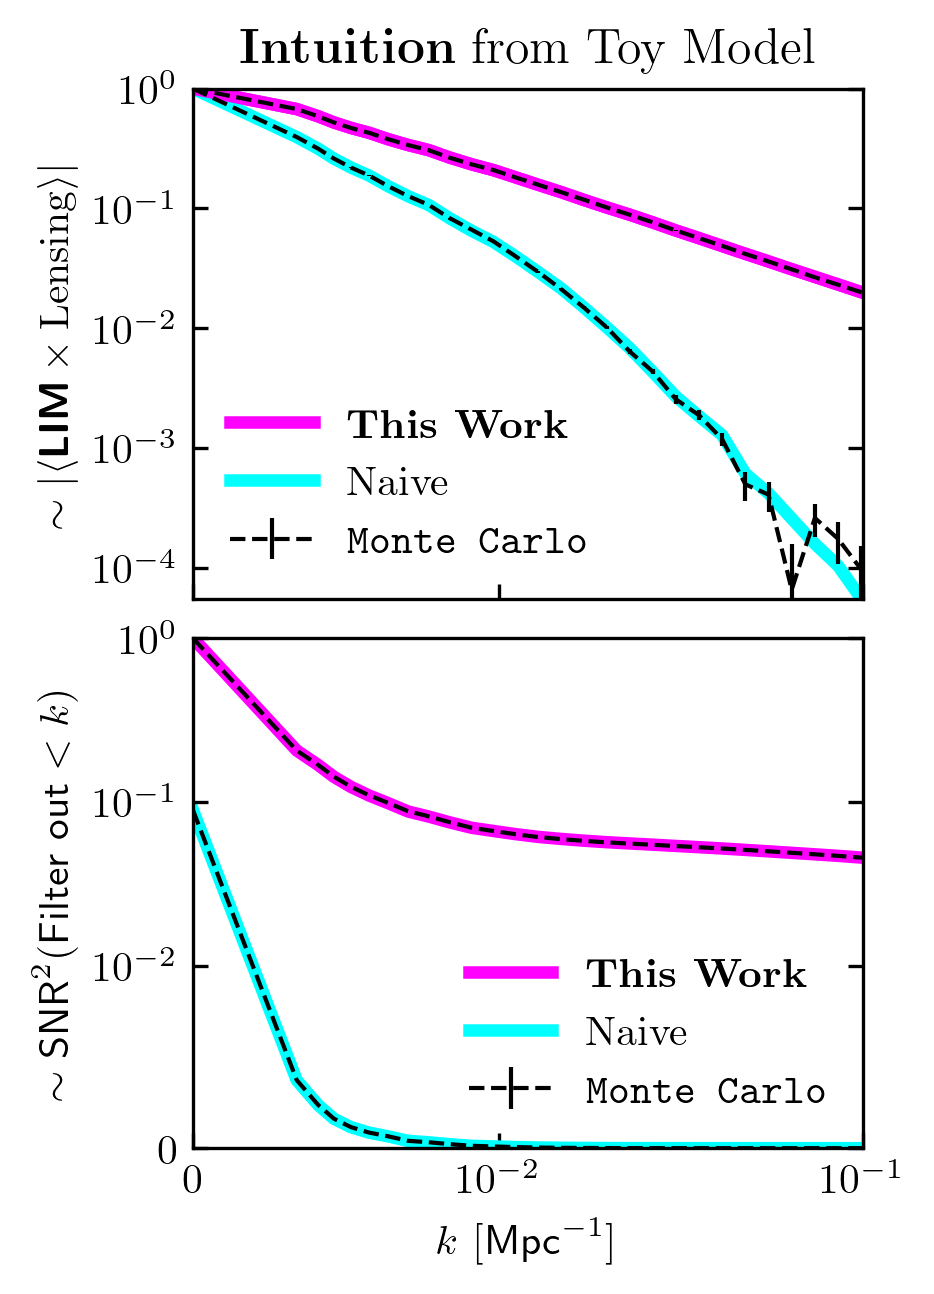

In [264]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)


# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/binned_Ik_kappa[0]), **params)
    # axs[0].scatter(x, jnp.abs(y/binned_Ik_kappa[0]))
    

_alpha = {'LC':1, 'nLC': jnp.abs(binned_Ik_kappa[0]/binned_Ik_kappa_noLC[0])}


_plot(k_bin_centers, binned_Ik_kappa, 
         label=r'\textbf{This Work}', c=LC_k, lw=3,)

_plot(k_bin_centers, _alpha['nLC']*binned_Ik_kappa_noLC, 
         label='Naive', c=nLC_color, lw=nLC_lw, ls='-')
_plot(k_bin_centers, binned_Ik_kappa, c=LC_k, lw=3,)

for _type in ['LC', 'nLC']:
    curr_spectra = _alpha[_type] * jnp.abs(measured_spectra['estimated_'+_type+'_Ik'])
    binned_rmse  = _alpha[_type] * jnp.sqrt(measured_spectra['estimated_'+_type+'_Ik_MSE'])
            
    axs[0].errorbar(k_bin_centers, 
                    curr_spectra/np.abs(binned_Ik_kappa)[0], 
                    yerr=jnp.abs(binned_rmse)/np.abs(binned_Ik_kappa)[0], 
                    lw=1,
                    ls='--', c=color[_type])



axs[0].errorbar([0, 100], [100, 100], yerr=0, lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')

axs[0].set_yscale('log')
_idxs = jnp.where(k_bin_centers <= 1e-1)
axs[0].set_ylim(_alpha['nLC']*jnp.min(jnp.abs(binned_Ik_kappa_noLC[_idxs] / binned_Ik_kappa[0])), 1e0)
# _alpha['nLC']*jnp.min(jnp.abs(binned_Ik_kappa_noLC[_idxs] / binned_Ik_kappa[0]))
# axs[0].set_ylim(1e-3, 1e0)

axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')
# axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')



# SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s['theoryLC'][0], **params)

_plot(k_bin_centers, SNR2s['theoryLC'], c=LC_k, lw=3, label=r'\textbf{This Work}')
_plot(k_bin_centers, SNR2s['theorynLC'], c=nLC_color, lw=nLC_lw, label='Naive')

for _type in ['LC', 'nLC']:
    # _plot(k_bin_centers, SNR2s[_type], c=color[_type], lw=1, ls='--')
    axs[1].errorbar(k_bin_centers, (SNR2s[_type]/SNR2s['theoryLC'][0]),
                        yerr=(jnp.sqrt(SNR2s[_type+'_MSE'])/SNR2s['theoryLC'][0]),
                        lw=1,
                        ls='--', c=color[_type])
    
# _plot(Lambdas, SNR2s_proj, c='lightgrey', lw=1)
# _plot(Lambdas, jnp.real(estimated_Ik_proj**2/estimated_var_proj), 
#          c='yellow', lw=1, ls='--')

axs[1].errorbar([0, 100], [100, 100], yerr=0, lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')


# axs[1].set_yscale('log')
# axs[1].set_ylim(3e-7,1)
# axs[1].set_yticks([1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
axs[1].set_yscale('symlog', linthresh=1e-2)
axs[1].set_ylim(0, 1e0)


axs[1].set_ylabel(r'$\sim {\sf SNR}^2(\textsf{Filter out}<k)$')
axs[1].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

for ax in axs:
    ax.set_xscale('asinh', linear_width=3e-3)
    ax.set_xticks([0, 1e-2, 1e-1])
    ax.set_xlim(0, .1)
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='major', right=True)
    ax.tick_params(axis='y', which='minor', left=False)
    ax.yaxis.set_zorder(3)

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)


# from matplotlib.lines import Line2D
# from matplotlib.patches import Patch

# legend_elements = [
#     Line2D([0], [0], color=LC_k, lw=3, ls='-', label=r'\textbf{This Work}'),
#     Line2D([0], [0], color=nLC_color, lw=nLC_lw, ls='-', label=r'Naive'),
#     # Line2D([0], [0], color='k', lw=2, ls='--', label=r'\texttt{Monte Carlo}'),
# ]

# fig.legend(handles=legend_elements, 
#            loc='lower center',
#            bbox_to_anchor=(plt_cntr, 0.885),
#            frameon=False,
#            ncol=2)

axs[0].set_title(r'\textbf{Intuition} from Toy Model')
# axs[1].text(s=r'\textbf{Intuition} for'+'\n'+'Key Results'+'\n'+r'from \textsf{\textbf{Toy Model}}', 
#             x=8e-2, y=6e-3, horizontalalignment='right')


plt.savefig('figures/015.003.pdf', bbox_inches = 'tight')

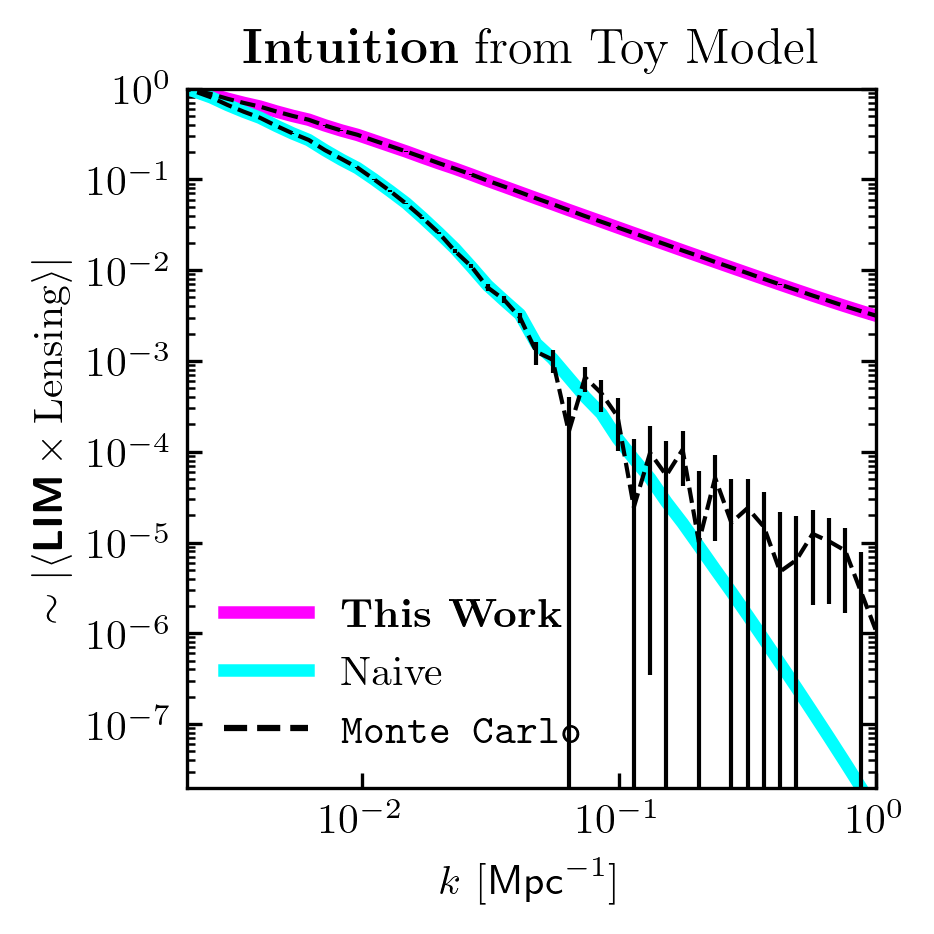

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(3,3), dpi=300)
axs = [axs]
axs[0].set_title(r'\textbf{Intuition} from Toy Model')

# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/y[1]), **params)
    # axs[0].scatter(x, jnp.abs(y/binned_Ik_kappa[0]))
    
_plot(k_bin_centers, binned_Ik_kappa, 
         label=r'\textbf{This Work}', c=LC_k, lw=3)

_plot(k_bin_centers, binned_Ik_kappa_noLC, 
         label='Naive', c=nLC_color, lw=nLC_lw, ls='-')

axs[0].errorbar(k_bin_centers, jnp.abs(measured_spectra['estimated_LC_Ik'])/np.abs(binned_Ik_kappa)[1], 
                    yerr=jnp.abs(jnp.sqrt(measured_spectra['estimated_LC_Ik_MSE']))/np.abs(binned_Ik_kappa)[1], 
                    lw=1,
                    ls='--', c=color[_type])


axs[0].errorbar(k_bin_centers, jnp.abs(measured_spectra['estimated_nLC_Ik'])/np.abs(binned_Ik_kappa_noLC)[1], 
                    yerr=jnp.abs(jnp.sqrt(measured_spectra['estimated_nLC_Ik_MSE']))/np.abs(binned_Ik_kappa_noLC)[1], 
                    lw=1,
                    ls='--', c=color[_type])


axs[0].plot([-100, -99, ], [-1000000, -1000000], c='k', ls='--', label=r'\texttt{Monte Carlo}')

# axs[0].set_yscale('symlog', linthresh=1e-2)
# axs[0].set_ylim(0, 1)

axs[0].set_yscale('log')

_idxs = jnp.where(k_bin_centers <= 1e0)
axs[0].set_ylim(jnp.min(jnp.abs(binned_Ik_kappa_noLC[_idxs] / binned_Ik_kappa_noLC[1])), 1e0)

axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')
axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

for ax in axs:
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='both', right=True)

plt.xscale('log')
plt.xlim(k_bin_centers[1], 1e0)

# axs[0].legend(frameon=False)
axs[0].legend(frameon=False, loc='lower left')

# plt.savefig('figures/015.003.pdf', bbox_inches = 'tight')

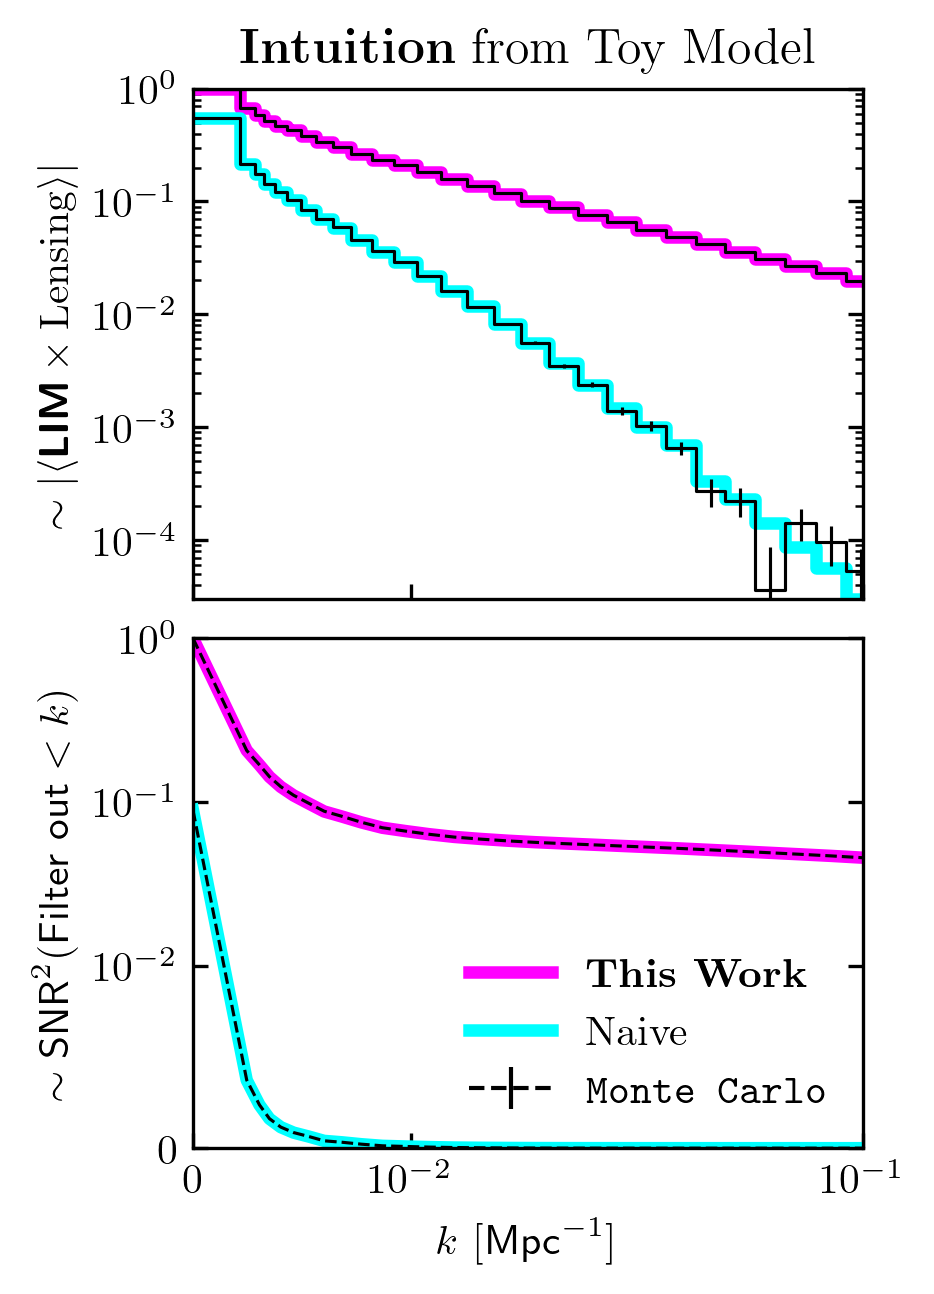

In [118]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(3,4.2), dpi=300)

axs[0].set_title(r'\textbf{Intuition} from Toy Model')

# <Ik> plot
def _plot(x, y, **params):
    axs[0].plot(x, jnp.abs(y/binned_Ik_kappa[0]), **params)
    # axs[0].scatter(x, jnp.abs(y/binned_Ik_kappa[0]))

axs[0].step(k_bin_edges, 
            jnp.abs(
                jnp.hstack(
                    [binned_Ik_kappa, binned_Ik_kappa[-1]]
                )
                /binned_Ik_kappa[0]
            ),
            where='post', lw=3, c=LC_k,)

axs[0].step(k_bin_edges, 
            jnp.abs(
                jnp.hstack(
                    [binned_Ik_kappa_noLC, binned_Ik_kappa_noLC[-1]]
                )
                /binned_Ik_kappa[0]
            ),
            where='post', lw=nLC_lw, c=nLC_color,)



# _plot(k_bin_centers, binned_Ik_kappa, 
#          label=r'\textbf{This Work}', c=LC_k, lw=3)

# _plot(k_bin_centers, binned_Ik_kappa_noLC, 
#          label='Naive', c=nLC_color, lw=nLC_lw, ls='-')

for _type in ['LC', 'nLC']:
    curr_spectra = jnp.abs(measured_spectra['estimated_'+_type+'_Ik'])
    binned_rmse = jnp.sqrt(measured_spectra['estimated_'+_type+'_Ik_MSE'])


    axs[0].step(k_bin_edges, 
                jnp.abs(
                    jnp.hstack(
                        [curr_spectra, curr_spectra[-1]]
                    )
                    /binned_Ik_kappa[0]
                ),
                where='post', lw=0.75, c='k', ls='-',)

    axs[0].errorbar(k_bin_centers, curr_spectra/np.abs(binned_Ik_kappa)[0], 
                    yerr=jnp.abs(binned_rmse)/np.abs(binned_Ik_kappa)[0], 
                    lw=0.75,
                    ls='none', c=color[_type])



axs[0].plot([-100, -99, ], [-1000000, -1000000], c='k', ls='--', label=r'\texttt{Monte Carlo}')

# axs[0].set_yscale('symlog', linthresh=1e-2)
# axs[0].set_ylim(0, 1)

axs[0].set_yscale('log')
# axs[0].set_ylim(1e-4, 1e0)
_idxs = jnp.where(k_bin_centers <= 1e-1)
axs[0].set_ylim(jnp.min(jnp.abs(binned_Ik_kappa_noLC[_idxs] / binned_Ik_kappa[0])), 1)


axs[0].set_ylabel(r'$\sim |\langle \textbf{\textsf{LIM}}\times \rm{Lensing}\rangle|$')
# axs[0].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')



# SNR2 Plot
def _plot(x, y, **params):
    axs[1].plot(x, y/SNR2s['theoryLC'][0], **params)

_plot(k_bin_centers, SNR2s['theoryLC'], c=LC_k, lw=3, label=r'\textbf{This Work}')
_plot(k_bin_centers, SNR2s['theorynLC'], c=nLC_color, lw=nLC_lw, label='Naive')

for _type in ['LC', 'nLC']:
    # _plot(k_bin_centers, SNR2s[_type], c=color[_type], lw=1, ls='--')
    axs[1].errorbar(k_bin_centers, (SNR2s[_type]/SNR2s['theoryLC'][0]),
                        yerr=(jnp.sqrt(SNR2s[_type+'_MSE'])/SNR2s['theoryLC'][0]),
                        lw=0.75,
                        ls='--', c=color[_type])
    
# _plot(Lambdas, SNR2s_proj, c='lightgrey', lw=1)
# _plot(Lambdas, jnp.real(estimated_Ik_proj**2/estimated_var_proj), 
#          c='yellow', lw=1, ls='--')

axs[1].errorbar([0, 100], [100, 100], yerr=0, lw=1, c='k', ls='--', label=r'\texttt{Monte Carlo}')


# axs[1].set_yscale('log')
# axs[1].set_ylim(1e-6,2e0)
axs[1].set_yscale('symlog', linthresh=1e-2)
axs[1].set_ylim(0, 1e0)


axs[1].set_ylabel(r'$\sim {\sf SNR}^2(\textsf{Filter out}<k)$')
axs[1].set_xlabel(r'$k$ [${\sf Mpc}^{-1}$]')

for ax in axs:
    ax.set_xscale('asinh', linear_width=8e-3)
    ax.set_xticks([0, 1e-2, 1e-1])
    ax.set_xlim(0, .1)
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.tick_params(axis='y', which='both', right=True)

# axs[0].legend(frameon=False)
axs[1].legend(frameon=False, loc='lower right')

# plt.savefig('figures/015.003.pdf', bbox_inches = 'tight')